In [218]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import math
from pennylane.optimize import AdamOptimizer


In [219]:
#Global Control Variables
k_helper = None
k_global_search_max = None
k_global_search_min = None

test_input = [0.6, 0.3, 0.0, 0.1, 0.0, 0.5,0.0,0.0,0.0,0.0,0.0,0.1,0.1,0.0, 0.0, 0.0]
num_of_qubits_test = int(np.log2(len(test_input)))
num_overflow_bit = 1


In [220]:
def add_k_sign(k, wires):
    #sign handling
    bin_rep = np.binary_repr(k,len(wires))
    k = int(bin_rep,2)

    qml.QFT(wires=wires)
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])
    qml.adjoint(qml.QFT)(wires=wires)

In [221]:
num_qubits = num_of_qubits_test + num_overflow_bit


num_of_qubits_vqs = num_qubits + 1
eps_val_q = 1/math.sqrt(2**num_of_qubits_vqs)/100
eps_val = min(1e-10, eps_val_q)
tiny_change_threshold = 1e-4
cnt_threshold_no_change = 5


start_state = np.array(test_input)
start_state = start_state/np.linalg.norm(start_state)

initial_state2 = start_state.tolist()

initial_state_phi1 = initial_state2
print(f'initial_state_phi1={initial_state_phi1}')
initial_state_0_phi1  = initial_state_phi1 + [0]*len(initial_state_phi1) # 2**num_of_qubits

initial_state_phi1=[0.7022468831767834, 0.3511234415883917, 0.0, 0.11704114719613057, 0.0, 0.5852057359806528, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11704114719613057, 0.11704114719613057, 0.0, 0.0, 0.0]


In [222]:
device_name_standard_maker = 'default.qubit'
device_global_search = 'default.qubit' 
device_name3 = 'default.qubit' 




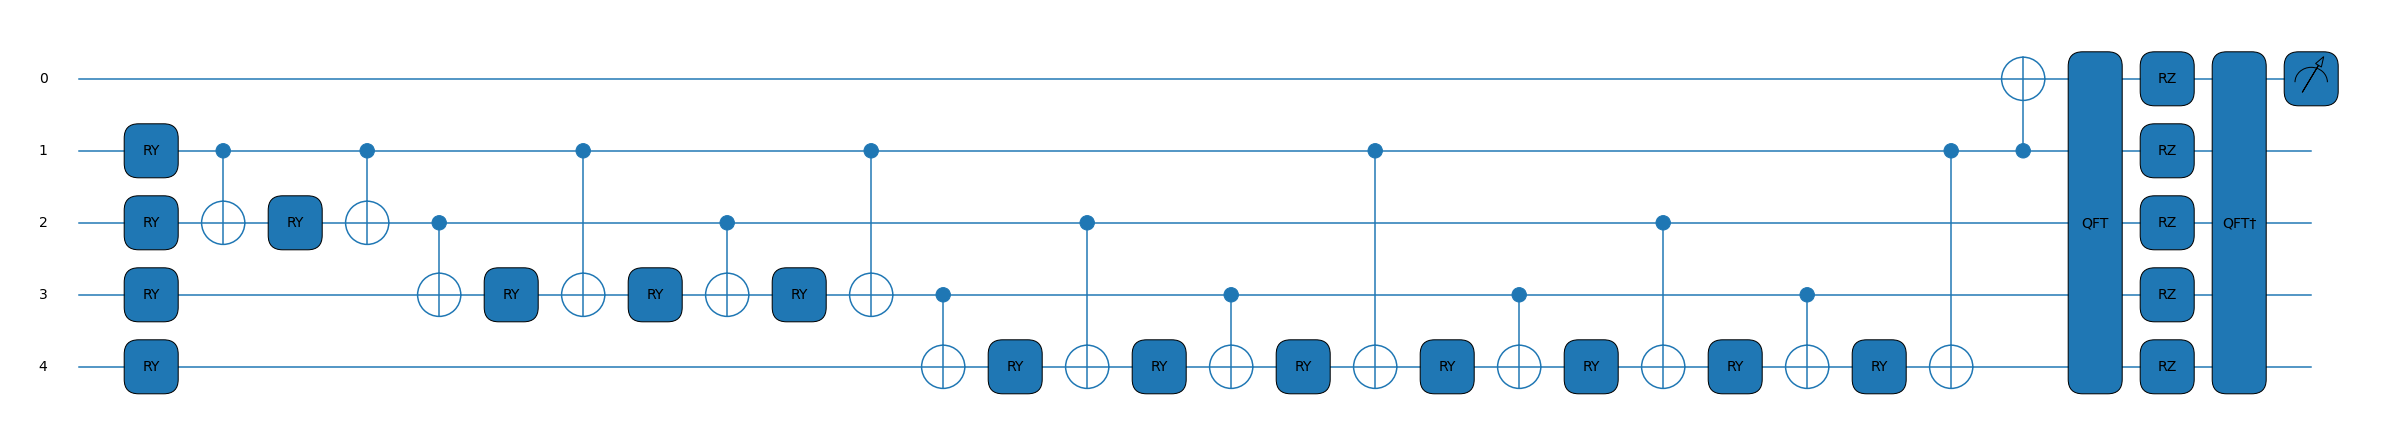

In [223]:
dev_standard_maker = qml.device(device_name_standard_maker, wires=num_qubits,shots=1024) 
@qml.qnode(dev_standard_maker)
def standard_maker_helper_circuit(k,input,wires):
    qml.QubitStateVector(np.array(input), wires=wires[1:])
    qml.CNOT(wires=[1,0]) # add some bits for handle overflow
    add_k_sign(k,wires=wires)
    return qml.expval(qml.PauliZ(wires=0))


qml.draw_mpl(standard_maker_helper_circuit, show_all_wires=True)(0,start_state,dev_standard_maker.wires)
plt.show()

-5
-4
-3
-2
-1


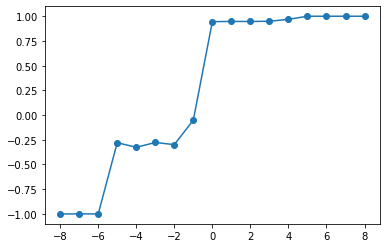

In [224]:

x=[i for i in range(-2**(num_qubits-1-1),2**(num_qubits-1-1)+1)]
y=[]
for i in x:
    exp_val = standard_maker_helper_circuit(i,start_state,dev_standard_maker.wires) 
    if(-0.5<exp_val<0.5):
        print(i)
        k_helper = i

    y.append(exp_val)

# plot scatter plot with x and y data
plt.scatter(x, y)
  
# plot with x and y data
plt.plot(x, y)

if(k_helper==None):
    print('Error in standard making')



In [225]:
dev_global_search = qml.device(device_global_search, wires=num_qubits,shots=1024) 
@qml.qnode(dev_global_search)
def global_search(k_new,k_helper,input,wires):
    qml.QubitStateVector(np.array(input), wires=wires[1:])
    qml.CNOT(wires=[1,0]) # add some bits for handle overflow
    add_k_sign(k_helper+k_new,wires=wires)
    return qml.expval(qml.PauliZ(wires=0))

-8
-7
-6
-5
1
2
3
4
5
6
7
8


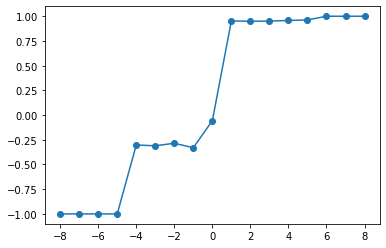

In [226]:
# Full Global Search
x=[i for i in range(-2**(num_qubits-1-1),2**(num_qubits-1-1)+1)]
y=[]
for i in x:
    exp_val = global_search(i,k_helper,start_state,dev_global_search.wires) 
    if(-0.85>exp_val):
        print(i)
        k_global_search_max = i
        
    if(exp_val>0.85):
        print(i)
        k_global_search_min = i
        
    y.append(exp_val)

# plot scatter plot with x and y data
plt.scatter(x, y)
  
# plot with x and y data
plt.plot(x, y)

if k_global_search_max == None:
    print('Error in finding global max')
if k_global_search_min == None:
    print('Error in finding global min')

-8
-7
-6
-5
1
2
3
4
5
6
7
8


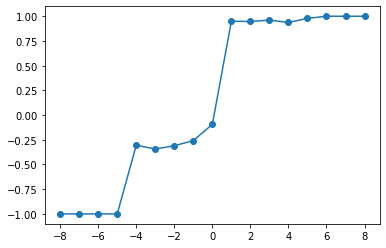

In [227]:
# Binary Global Search For Max and Min

range_max=[i for i in range(-2**(num_qubits-1-1),1)]
range_min=[i for i in range(0,2**(num_qubits-1-1)+1)]
size = len(range_max)
i_max=0
i_min=0

while k_global_search_max==None:
    exp_val = global_search(range_max[i_max],k_helper,start_state,dev_global_search.wires) 
    if(-0.85>exp_val):
        print(i)
        k_global_search_max = i
    else:
        i_max = int((size-i_max)/2)
        
        
while k_global_search_min==None:
    exp_val = global_search(range_max[i_min],k_helper,start_state,dev_global_search.wires) 
    if(exp_val>0.85):
        print(i)
        k_global_search_min = i
    else:
        i_min = int((size-i_min)/2)

print(k_helper)
print(k_global_search_max)
print(k_global_search_min)

